In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/colab/NF')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
!pip install torch --upgrade

     |████████████████████████████████| 748.9MB 19kB/s 
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0


In [4]:
#Define the model.
import torch

import NF #module for normalizing flows
import BAM #module for blockwise autoregressive monotonic transformations

mylayers = [BAM.LinearWeightNorm([1,1], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [1,1]), BAM.Gate([1,1])
           ]

mystack = BAM.Stack(*mylayers)

mycat = BAM.Cat(mystack, BAM.Gate([1,1]))

mysum = BAM.Stack(mycat, BAM.Sum([2,2]))

mynet = mysum.NF()

mynet.bisection_minimum = torch.empty(2).fill_(-5)
mynet.bisection_maximum = torch.empty(2).fill_(5)
mynet.bisection_max_iterations = 12

mylayers = [BAM.LinearWeightNorm([1,1], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [10,10]), BAM.Tanh([10,10]),
            BAM.LinearWeightNorm([10,10], [1,1]), BAM.Gate([1,1])
           ]

mystack = BAM.Stack(*mylayers)

mycat = BAM.Cat(mystack, BAM.Gate([1,1]))

mysum = BAM.Stack(mycat, BAM.Sum([2,2]))

mynet2 = mysum.NF()

mynet = NF.Stack(NF.Rotation(0,1), NF.Tanh(), mynet, NF.Rotation(0,1), NF.Tanh(), mynet2)

#I put NF.Tanh before each of the BAM.Stacks to make sure the BAM modules receive
# normailzed input so bisection can be initialized with a known range of (-1,+1).
# Alternatively, I can change mynet.bisection_minimum and maximum to large enough values.

#NF.Rotation modules can e.g. be replaced with NF.Permutation.

mynet

Stack(
  (0): Rotation()
  (1): Tanh()
  (2): ToNF(
    (_net): Stack(
      (0): Cat(
        (0): Stack(
          (0): LinearWeightNorm()
          (1): Tanh()
          (2): LinearWeightNorm()
          (3): Tanh()
          (4): LinearWeightNorm()
          (5): Tanh()
          (6): LinearWeightNorm()
          (7): Tanh()
          (8): LinearWeightNorm()
          (9): Gate()
        )
        (1): Gate()
      )
      (1): Sum()
    )
  )
  (3): Rotation()
  (4): Tanh()
  (5): ToNF(
    (_net): Stack(
      (0): Cat(
        (0): Stack(
          (0): LinearWeightNorm()
          (1): Tanh()
          (2): LinearWeightNorm()
          (3): Tanh()
          (4): LinearWeightNorm()
          (5): Tanh()
          (6): LinearWeightNorm()
          (7): Tanh()
          (8): LinearWeightNorm()
          (9): Gate()
        )
        (1): Gate()
      )
      (1): Sum()
    )
  )
)

In [5]:
#Train the model on the "moons" dataset from keras.
device = torch.device("cuda")
prior = torch.distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
mygen = NF.ToGenerator(mynet, prior).to(device)
optimizer = torch.optim.Adam(mygen.parameters())
batches = 10000
batchsize = 100

import sklearn.datasets
import numpy

for t in range(batches):
  noisy_moons = torch.from_numpy(sklearn.datasets.make_moons(n_samples=batchsize, noise=0.05)[0].astype(numpy.float32)).to(device)
  loss = mygen.crossentropy_loss(noisy_moons)
  optimizer.zero_grad()
  loss.backward()
  if (t%500 == 0):
    print(t, loss.item())
  optimizer.step()

0 19.224088668823242
500 3.494838237762451
1000 2.212899684906006
1500 1.6343508958816528
2000 1.266158938407898
2500 1.1572132110595703
3000 1.0011813640594482
3500 0.8813275098800659
4000 0.9920436143875122
4500 0.8582861423492432
5000 0.6817704439163208
5500 0.6903846859931946
6000 0.5744314193725586
6500 0.5384166240692139
7000 0.5635965466499329
7500 0.48404791951179504
8000 0.5172460079193115
8500 0.5165607333183289
9000 0.45049017667770386
9500 0.5007658004760742


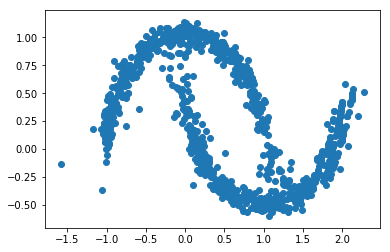

In [6]:
#Generate samples from the learned distribution.

import matplotlib.pyplot as plt

x = mygen.sample(1000).detach().cpu().numpy()
plt.scatter(x[:,0], x[:,1])

In [0]:
#Helper functions for initialization of (stacks of) coupling layers.
import torch

def create_mask(n, p=0.5):
  idx = torch.randperm(n)
  mask = torch.where(idx > p * (n - 1), torch.ones_like(idx), torch.zeros_like(idx)).bool()
  return mask

def create_t(n, h=[256,256]):
  net = torch.nn.Linear(n, h[0])
  for layer in range(1, len(h)):
    net = torch.nn.Sequential(net, torch.nn.LeakyReLU(), torch.nn.Linear(h[layer-1], h[layer]))
  net = torch.nn.Sequential(net, torch.nn.LeakyReLU(), torch.nn.Linear(h[-1], n))
  return net

def create_s(n, h=[256,256]):
  net = create_t(n, h)
  net = torch.nn.Sequential(net, torch.nn.Tanh())
  return net
  
def create_2cl(n, p=0.5, ht=[256,256], hs=[256,256]):
  mask = create_mask(n, p)
  t1 = create_t(n, ht)
  t2 = create_t(n, ht)
  s1 = create_s(n, hs)
  s2 = create_s(n, hs)
  cl1 = NFCouplingLayer(s1, t1, mask)
  cl2 = NFCouplingLayer(s2, t2, ~mask)
  return NFStack(cl1, cl2)

def create_flownet(n, d=3, p=None, ht=None, hs=None):
  if p is None: p = [0.5] * d
  if ht is None: ht = [[256,256]] * d
  if hs is None: hs = [[256,256]] * d
  assert(len(p) == len(ht) == len(hs) == d)
  net = create_2cl(n, p[0], ht[0], hs[0])
  for i in range(1, d):
    net.add_module(str(i), create_2cl(n, p[i], ht[i], hs[i]))
  return net

n = 2
mynet = create_flownet(n)

mynet

In [0]:
#Train model on the "moons" dataset from keras.
device = torch.device("cuda")
prior = torch.distributions.MultivariateNormal(torch.zeros(n).to(device), torch.eye(n).to(device))
mygen = NFGenerator(mynet, prior).to(device)
optimizer = torch.optim.Adam(mygen.parameters())
batches = 10000
batchsize = 100

import sklearn.datasets
import numpy

for t in range(batches):
  noisy_moons = torch.from_numpy(sklearn.datasets.make_moons(n_samples=batchsize, noise=0.05)[0].astype(numpy.float32)).to(device)
  #we need noise because data distribution needs to be smooth enough for our model to fit
  loss = mygen.crossentropy_loss(noisy_moons)
  optimizer.zero_grad()
  loss.backward()
  if (t%500 == 0):
    print(t, loss.item())
  optimizer.step()

In [0]:
#Generate samples from learned distribution.
import matplotlib.pyplot as plt

x = mygen.sample(1000).detach().cpu().numpy()
plt.scatter(x[:,0], x[:,1])